##### Set up packages and directories

In [1]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, fftfreq
from Bio import Entrez, SeqIO, AlignIO, pairwise2, Align, Seq, motifs
from Bio.Seq import Seq
from Bio.SeqFeature import SeqFeature, FeatureLocation
from scipy.stats import binom
import math
from tqdm.auto import tqdm
from Comparative_Analysis import Sequence_Analysis_Routines as sar
from Comparative_Analysis import HMM as hmm
from Comparative_Analysis import Utilities as util
from Comparative_Analysis import Alignment_HMM as alignment_hmm
from Comparative_Analysis import Alignment_Analysis as alignment_analysis
from Comparative_Analysis import Alignment as align
from Comparative_Analysis import Master_Alignment_HMM as master_alignment_hmm
from Comparative_Analysis import Multi_Species_Master_Alignment_HMM as multi_species_master_alignment_hmm
from Comparative_Analysis import Arneson_Ernst_HMM as ae_hmm
import random
import copy
from joblib import Parallel, delayed
import os
import subprocess
from Bio.Blast import NCBIWWW, NCBIXML

In [2]:
project_dir = 'D:/Project_Data/Project_6'
literature_datasets_dir = project_dir + '/Datasets/Data_From_Publications'
genome_datasets_dir = project_dir + '/Datasets/NCBI_Datasets'
output_dir = project_dir + '/Output'
refseq_dir = 'D:/Tests/NCBI_Dataset_Mycobacteria'
num_cores = 16
core_numbers = list(range(1, num_cores+1))

In [3]:
species_list = util.list_dirs(refseq_dir)
reference_species = 'GCF_000195955.2'
print(len(species_list))

3


##### Translation function

In [4]:
codon_dict = {}
with open('D:/Project_Data/Project_3/Datasets/Reference_Tables/Standard_Code.txt') as f:
    for l in f:
        codon_dict[str(l[1:4])] = l[5]
def translate_sequence(input_seq, strand, rf):
    output_seq = ''
    if strand == 1:
        seq = input_seq[rf:]
    else:
        seq = align.reverse_complement(input_seq)[rf:]
    for i in range(0,len(seq)-2,3):
        if seq[i:(i+3)] in codon_dict:
            output_seq += codon_dict[seq[i:(i+3)]]
        else:
            output_seq += 'X'
    return output_seq

In [5]:
def translate_orf(sequence, start, end, strand):
    return translate_sequence(sequence[start:end], strand, 0)              

##### Output nt sequences in FASTA format

In [6]:
def produce_blast_file(record_list, output_filename):
    with open(output_filename, 'w',  newline='') as outfile:
        line_length = 60
        for record in tqdm(record_list):
            sequence = record[1]
            lines = []
            sequence_length = len(sequence)
            number_of_lines = math.ceil(sequence_length / line_length)
            lines.append(">" +record[0]+ "\n")
            for i in range(number_of_lines):
                subsequence = sequence[i*line_length:(i+1)*line_length]
                lines.append(subsequence + "\n")
            outfile.write(''.join(lines))

##### Function to find maximal open reading frame between two co-ordinates with mutation probability less than defined p-value

In [7]:
def find_all_maximal_orfs(sequence, seq_start, seq_stop, output_all_orfs = False, min_orf_length = 0):
    max_len = 0
    orfs_found = []
    start_pos = -999
    end_pos = -999
    for frame in ['Forward', 'Reverse']:
        if frame == 'Forward':
            temp = (sequence[seq_start: seq_stop])
        else:
            temp = align.reverse_complement(sequence[seq_start: seq_stop])
        seq_len = len(temp)
        for rf in range(3):
            i = rf
            while i < seq_len - 2:
                orf_length = 0
                test_codon = temp[i: i+3] 
                if test_codon in ['ATG','GTG','TTG']:  
                    for j in range(i + 3, seq_len - 2, 3):
                        test_codon_2 = temp[j: j+3] 
                        if test_codon_2 in ['TAG','TGA','TAA']:
                            orf_length = j - i
                            break
                            
                if orf_length > 0:
                    if frame == 'Forward':
                        orf_start =  seq_start + i
                        orf_end = seq_start + j+3
                        orf_strand = 1
                    else:
                        orf_start =  seq_start + seq_len-(j+3)
                        orf_end = seq_start + seq_len-i
                        orf_strand = -1
                    
                    if orf_length >= min_orf_length:
                        orfs_found.append((orf_start, orf_end, orf_strand, orf_length))

                if orf_length > max_len and orf_length >= min_orf_length:                                           
                    max_len = orf_length
                    start_pos = orf_start
                    end_pos = orf_end
                    strand = orf_strand 

                if orf_length > 0:
                    i = j
                else:
                    i +=3
    if output_all_orfs == True:
        sorted_orfs = sorted(orfs_found, key=lambda x: x[3], reverse=True)
        return sorted_orfs                
    elif start_pos == -999:
        return(0,0,0,0)
    else:
        return(start_pos, end_pos, strand, max_len)   

##### Extract full sequences from each organism

In [8]:
full_sequences = []
cds_boundary_dict = {}
mycobrowser_df = pd.read_excel(literature_datasets_dir+'/Mycobrowser_Release_4.xlsx')
for i, species in tqdm(enumerate(species_list)):
    temp = []
    genome_record = next(SeqIO.parse(genome_datasets_dir + '/'+species+'/genomic.gbff', "genbank"))
    full_sequences.append(str(genome_record.seq))
    if species == reference_species:
        reference_species_index = i
        temp_cds = mycobrowser_df[mycobrowser_df['Feature'] == 'CDS'][['Locus','Start','Stop','Strand','Function']]      #Just CDS
        for i, r in temp_cds.iterrows():
            if r['Strand'] == '+':
                strand = 1
            else:
                strand = -1
            temp.append((r['Locus'],r['Start']-1, r['Stop'], strand))
    else:
        for feature in genome_record.features:
                a = feature.qualifiers
                if a.get("locus_tag")!= None and feature.type == 'CDS':
                    locus_tag = a.get("locus_tag")[0]
                    temp.append([locus_tag, int(feature.location.start), int(feature.location.end), int(feature.location.strand)])
    cds_boundary_dict[species] = temp

0it [00:00, ?it/s]

##### Find maximal ORFs in all frames

In [9]:
maximal_orfs = []
for sequence in tqdm(full_sequences):
    maximal_orfs.append(find_all_maximal_orfs(sequence, 0, len(sequence), True, 200))

  0%|          | 0/3 [00:00<?, ?it/s]

In [10]:
maximal_orf_dicts = []
maximal_proteins = []
reference_proteins = []
for j, orf_list in enumerate(maximal_orfs):
    temp_dict = {}
    for i, orf in enumerate(orf_list):
        temp = translate_orf(full_sequences[j], orf[0], orf[1], orf[2])
        maximal_proteins.append([species_list[j]+'_'+str(i), temp[:-1]])
        temp_dict[species_list[j]+'_'+str(i)] = orf
        if j == reference_species_index:
            reference_proteins.append([species_list[j]+'_'+str(i), temp[:-1]])
    maximal_orf_dicts.append(temp_dict)
produce_blast_file(maximal_proteins, refseq_dir + '/maximal_proteins.faa')
produce_blast_file(reference_proteins, refseq_dir + '/reference_proteins.faa')

  0%|          | 0/85262 [00:00<?, ?it/s]

  0%|          | 0/24551 [00:00<?, ?it/s]

In [11]:
morf_details_dict = {}
for i, species in enumerate(species_list):
    for k, orf in maximal_orf_dicts[i].items():
        morf_details_dict[k] = [orf]
        for cds in cds_boundary_dict[species]:
            if orf[0] <= cds[1] and orf[1] >= cds[2] and orf[2] == cds[3] and (orf[0]-cds[1])%3 == 0:
                morf_details_dict[k].append(cds)

##### Create blast database

In [12]:
if 1==1:
    w_d = os.getcwd()
    os.chdir("D:/")
    subprocess.run('cd d:\\Tests\\NCBI_Dataset_Mycobacteria & makeblastdb -in maximal_proteins.faa -dbtype prot -out max_prot', shell=True, capture_output = True)
    os.chdir(w_d)

In [13]:
if 1==1:
    w_d = os.getcwd()
    os.chdir("D:/")
    subprocess.run('cd d:\\BLAST\\maxprot & blastp -query d:\\Tests\\NCBI_Dataset_Mycobacteria\\reference_proteins.faa -db max_prot -out blastp_results.csv -evalue 0.000000001 -seg no -outfmt "10 qaccver saccver qlen slen pident length mismatch gapopen qstart qend sstart send sstrand evalue bitscore" -num_threads 16', shell=True, capture_output = True)
    os.chdir(w_d)

In [28]:
blast_results = pd.read_csv("D:\\BLAST\\maxprot\\blastp_results.csv", header = None)
blast_results.columns = ['query_accession_ver', 'subject_accession_ver', 'query_length', 'subject_length', 'percent_identical_matches','alignment_length', 'number_mismatches', 'number_of_gap_openings', 'query_start_alignment', 'query_end_alignment', 'subject_start_alignment', 'subject_end_alignment', 'subject_strand', 'e_value', 'bit_score']

In [29]:
blast_results = blast_results.query('subject_length == subject_end_alignment and query_length == query_end_alignment')
blast_results = blast_results.query('not (subject_accession_ver.str.contains(@reference_species))')
blast_results['query_info']=  blast_results['query_accession_ver'].map(morf_details_dict)
blast_results['subject_info']=  blast_results['subject_accession_ver'].map(morf_details_dict)

In [30]:
for i, r in blast_results.iterrows():
    blast_results.at[i, 'query_species'] = '_'.join(r.query_accession_ver.split('_')[:-1])
    blast_results.at[i, 'subject_species'] = '_'.join(r.subject_accession_ver.split('_')[:-1])
    if len(r.query_info) > 1:
        blast_results.at[i, 'annotated_cds_in_query'] = 'Y'
    else:
        blast_results.at[i, 'annotated_cds_in_query'] = 'N'
    if len(r.subject_info) > 1:
        blast_results.at[i, 'annotated_cds_in_subject'] = 'Y'
    else:
        blast_results.at[i, 'annotated_cds_in_subject'] = 'N'
    if r.query_info[0][2] == 1:
        blast_results.at[i, 'query_start_pos'] = r.query_info[0][0] + (r.query_start_alignment - 1) * 3
        blast_results.at[i, 'query_end_pos'] = r.query_info[0][0] + (r.query_end_alignment - 1) * 3 + 6 # doesn't include stop codon in blast
    else:
        blast_results.at[i, 'query_start_pos'] = r.query_info[0][0] + (r.query_end_alignment - r.query_length) * 3
        blast_results.at[i, 'query_end_pos'] = r.query_info[0][1] - (r.query_start_alignment - 1) * 3
       
    if r.subject_info[0][2] == 1:
        blast_results.at[i, 'subject_start_pos'] = r.subject_info[0][0] + (r.subject_start_alignment - 1) * 3
        blast_results.at[i, 'subject_end_pos'] = r.subject_info[0][0] + (r.subject_end_alignment - 1) * 3 + 6 # doesn't include stop codon in blast
    else:
        blast_results.at[i, 'subject_start_pos'] = r.subject_info[0][0] + (r.subject_end_alignment - r.subject_length) * 3
        blast_results.at[i, 'subject_end_pos'] = r.subject_info[0][1] - (r.subject_start_alignment - 1) * 3

In [31]:
blast_results = blast_results.loc[blast_results.groupby(['query_accession_ver','subject_species'])['bit_score'].idxmax()]

In [32]:
blast_results.to_csv(project_dir + '/temp.csv')

<Figure size 1152x1152 with 0 Axes>

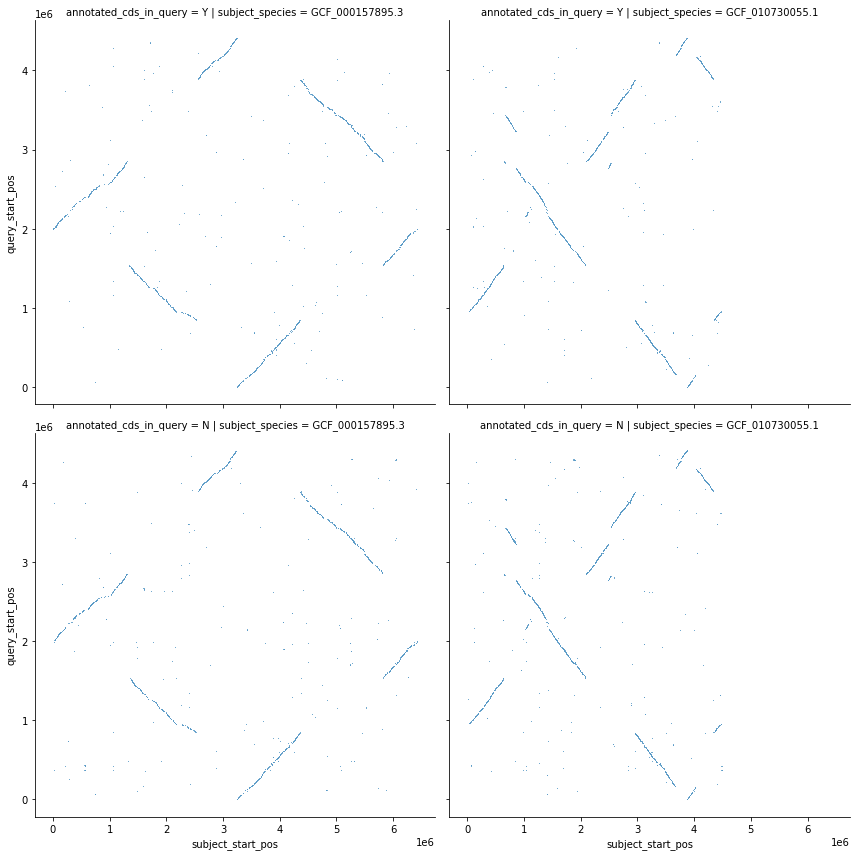

In [45]:
plt.figure(figsize=(16, 16))
g = sns.FacetGrid(blast_results, col='subject_species', row = 'annotated_cds_in_query', height=6)
g.map(sns.scatterplot, 'subject_start_pos', 'query_start_pos', s=1)
#sns.scatterplot(data = blast_results, y = 'subject_start_pos', x = 'query_start_pos', s=1, hue = 'annotated_cds_in_query')

In [35]:
blast_results.groupby(['subject_species','annotated_cds_in_query']).count()

query_accession_ver  \
subject_species annotated_cds_in_query                        
GCF_000157895.3 N                                      1867   
                Y                                      1675   
GCF_010730055.1 N                                      2615   
                Y                                      1743   

                                        subject_accession_ver  query_length  \
subject_species annotated_cds_in_query                                        
GCF_000157895.3 N                                        1867          1867   
                Y                                        1675          1675   
GCF_010730055.1 N                                        2615          2615   
                Y                                        1743          1743   

                                        subject_length  \
subject_species annotated_cds_in_query                   
GCF_000157895.3 N                                 1867   
                Y                                 1675   
GCF_010730055.1 N                                 2615   
                Y                                 1743   

                                        percent_identical_matches  \
subject_species annotated_cds_in_query                              
GCF_000157895.3 N                                            1867   
                Y                                            1675   
GCF_010730055.1 N                                            2615   
                Y                                            1743   

                                        alignment_length  number_mismatches  \
subject_species annotated_cds_in_query                                        
GCF_000157895.3 N                                   1867               1867   
                Y                                   1675               1675   
GCF_010730055.1 N                                   2615               2615   
                Y                                   1743               1743   

                                        number_of_gap_openings  \
subject_species annotated_cds_in_query                           
GCF_000157895.3 N                                         1867   
                Y                                         1675   
GCF_010730055.1 N                                         2615   
                Y                                         1743   

                                        query_start_alignment  \
subject_species annotated_cds_in_query                          
GCF_000157895.3 N                                        1867   
                Y                                        1675   
GCF_010730055.1 N                                        2615   
                Y                                        1743   

                                        query_end_alignment  ...  e_value  \
subject_species annotated_cds_in_query                       ...            
GCF_000157895.3 N                                      1867  ...     1867   
                Y                                      1675  ...     1675   
GCF_010730055.1 N                                      2615  ...     2615   
                Y                                      1743  ...     1743   

                                        bit_score  query_info  subject_info  \
subject_species annotated_cds_in_query                                        
GCF_000157895.3 N                            1867        1867          1867   
                Y                            1675        1675          1675   
GCF_010730055.1 N                            2615        2615          2615   
                Y                            1743        1743          1743   

                                        query_species  \
subject_species annotated_cds_in_query                  
GCF_000157895.3 N                                1867   
                Y                                1

In [50]:
temp_df = pd.DataFrame(blast_results.groupby(['query_accession_ver', 'annotated_cds_in_query']).count())
temp_df.groupby(['subject_accession_ver','annotated_cds_in_query']).count()

query_length  subject_length  \
subject_accession_ver annotated_cds_in_query                                 
1                     N                               2620            2620   
                      Y                                792             792   
2                     N                                931             931   
                      Y                               1313            1313   

                                              percent_identical_matches  \
subject_accession_ver annotated_cds_in_query                              
1                     N                                            2620   
                      Y                                             792   
2                     N                                             931   
                      Y                                            1313   

                                              alignment_length  \
subject_accession_ver annotated_cds_in_query                     
1                     N                                   2620   
                      Y                                    792   
2                     N                                    931   
                      Y                                   1313   

                                              number_mismatches  \
subject_accession_ver annotated_cds_in_query                      
1                     N                                    2620   
                      Y                                     792   
2                     N                                     931   
                      Y                                    1313   

                                              number_of_gap_openings  \
subject_accession_ver annotated_cds_in_query                           
1                     N                                         2620   
                      Y                                          792   
2                     N                                          931   
                      Y                                         1313   

                                              query_start_alignment  \
subject_accession_ver annotated_cds_in_query                          
1                     N                                        2620   
                      Y                                         792   
2                     N                                         931   
                      Y                                        1313   

                                              query_end_alignment  \
subject_accession_ver annotated_cds_in_query                        
1                     N                                      2620   
                      Y                                       792   
2                     N                                       931   
                      Y                                      1313   

                                              subject_start_alignment  \
subject_accession_ver annotated_cds_in_query                            
1                     N                                          2620   
                      Y                                           792   
2                     N                                           931   
                      Y                                          1313   

                                              subject_end_alignment  ...  \
subject_accession_ver annotated_cds_in_query                         ...   
1                     N                                        2620  ...   
                      Y                                         792  ...   
2                     N                                         931  ...   
                      Y                                        1313  ...   

                                              bit_score  query_info  \
subject_accession_ver annotated_cds_in_query                          
1            